In [1]:
%load_ext autoreload

In [58]:
%autoreload
import os
os.chdir(os.path.expanduser("/notebooks/segmentation"))
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from PIL import Image
import PIL

from train_utils.utils import mIoU, Lion
from plotter.plot import plot_prediction
from train_utils.unet_pipeline_trainer import train

import batchflow.batchflow as bf
from batchflow.batchflow import B, M, V, Notifier, Pipeline
from batchflow.batchflow.models.torch import TorchModel
from batchflow.batchflow import B, M, V, C, Notifier, Pipeline, Dataset
from batchflow.batchflow.models.torch.unet import UNet as Unet_bf
from batchflow.batchflow.opensets import PascalSegmentation
from batchflow.batchflow.plotter.plot import plot

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_params = {
    'BATCH_SIZE': 96,
    'LR': 1e-4,
    'NUM_CLASSES': 21,
    'NUM_EPOCHS': 280,
    'IMAGE_SHAPE': (256, 256)
}

In [4]:
ds = PascalSegmentation()
ds.split([0.7, 0.2, 0.1], shuffle=False)

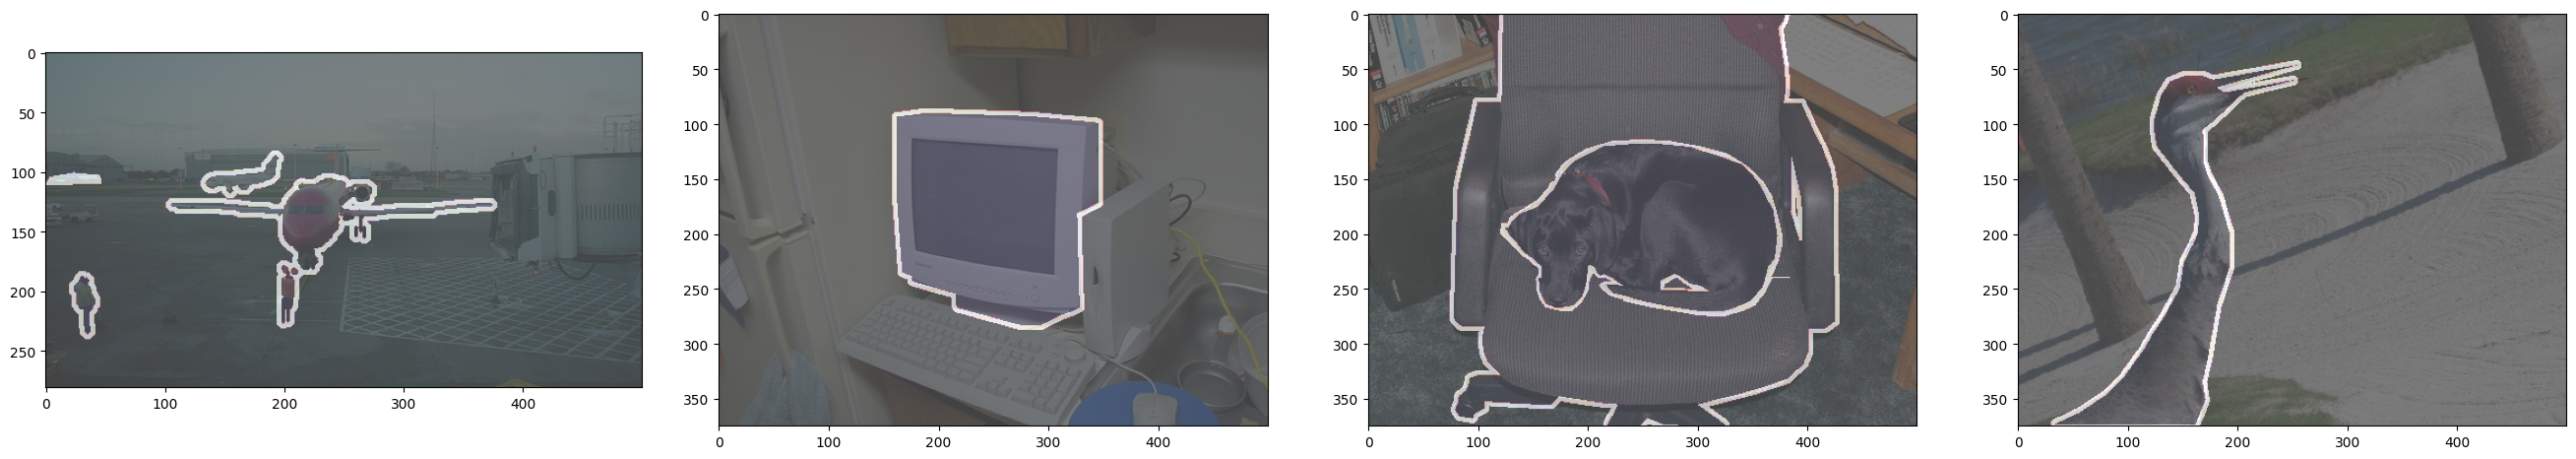

In [59]:
plot(
    data=[[np.array(ds.images[0]), np.array(ds.labels[0])], 
          [np.array(ds.images[1]), np.array(ds.labels[1])], 
          [np.array(ds.images[2]), np.array(ds.labels[2])],
          [np.array(ds.images[3]), np.array(ds.labels[3])]],
    cmap='batchflow',
    alpha=0.5
)

In [33]:
config = Unet_bf.default_config()
config['decay'] = {'name': 'cos', 'T_max': 6000,'frequency': 1500}

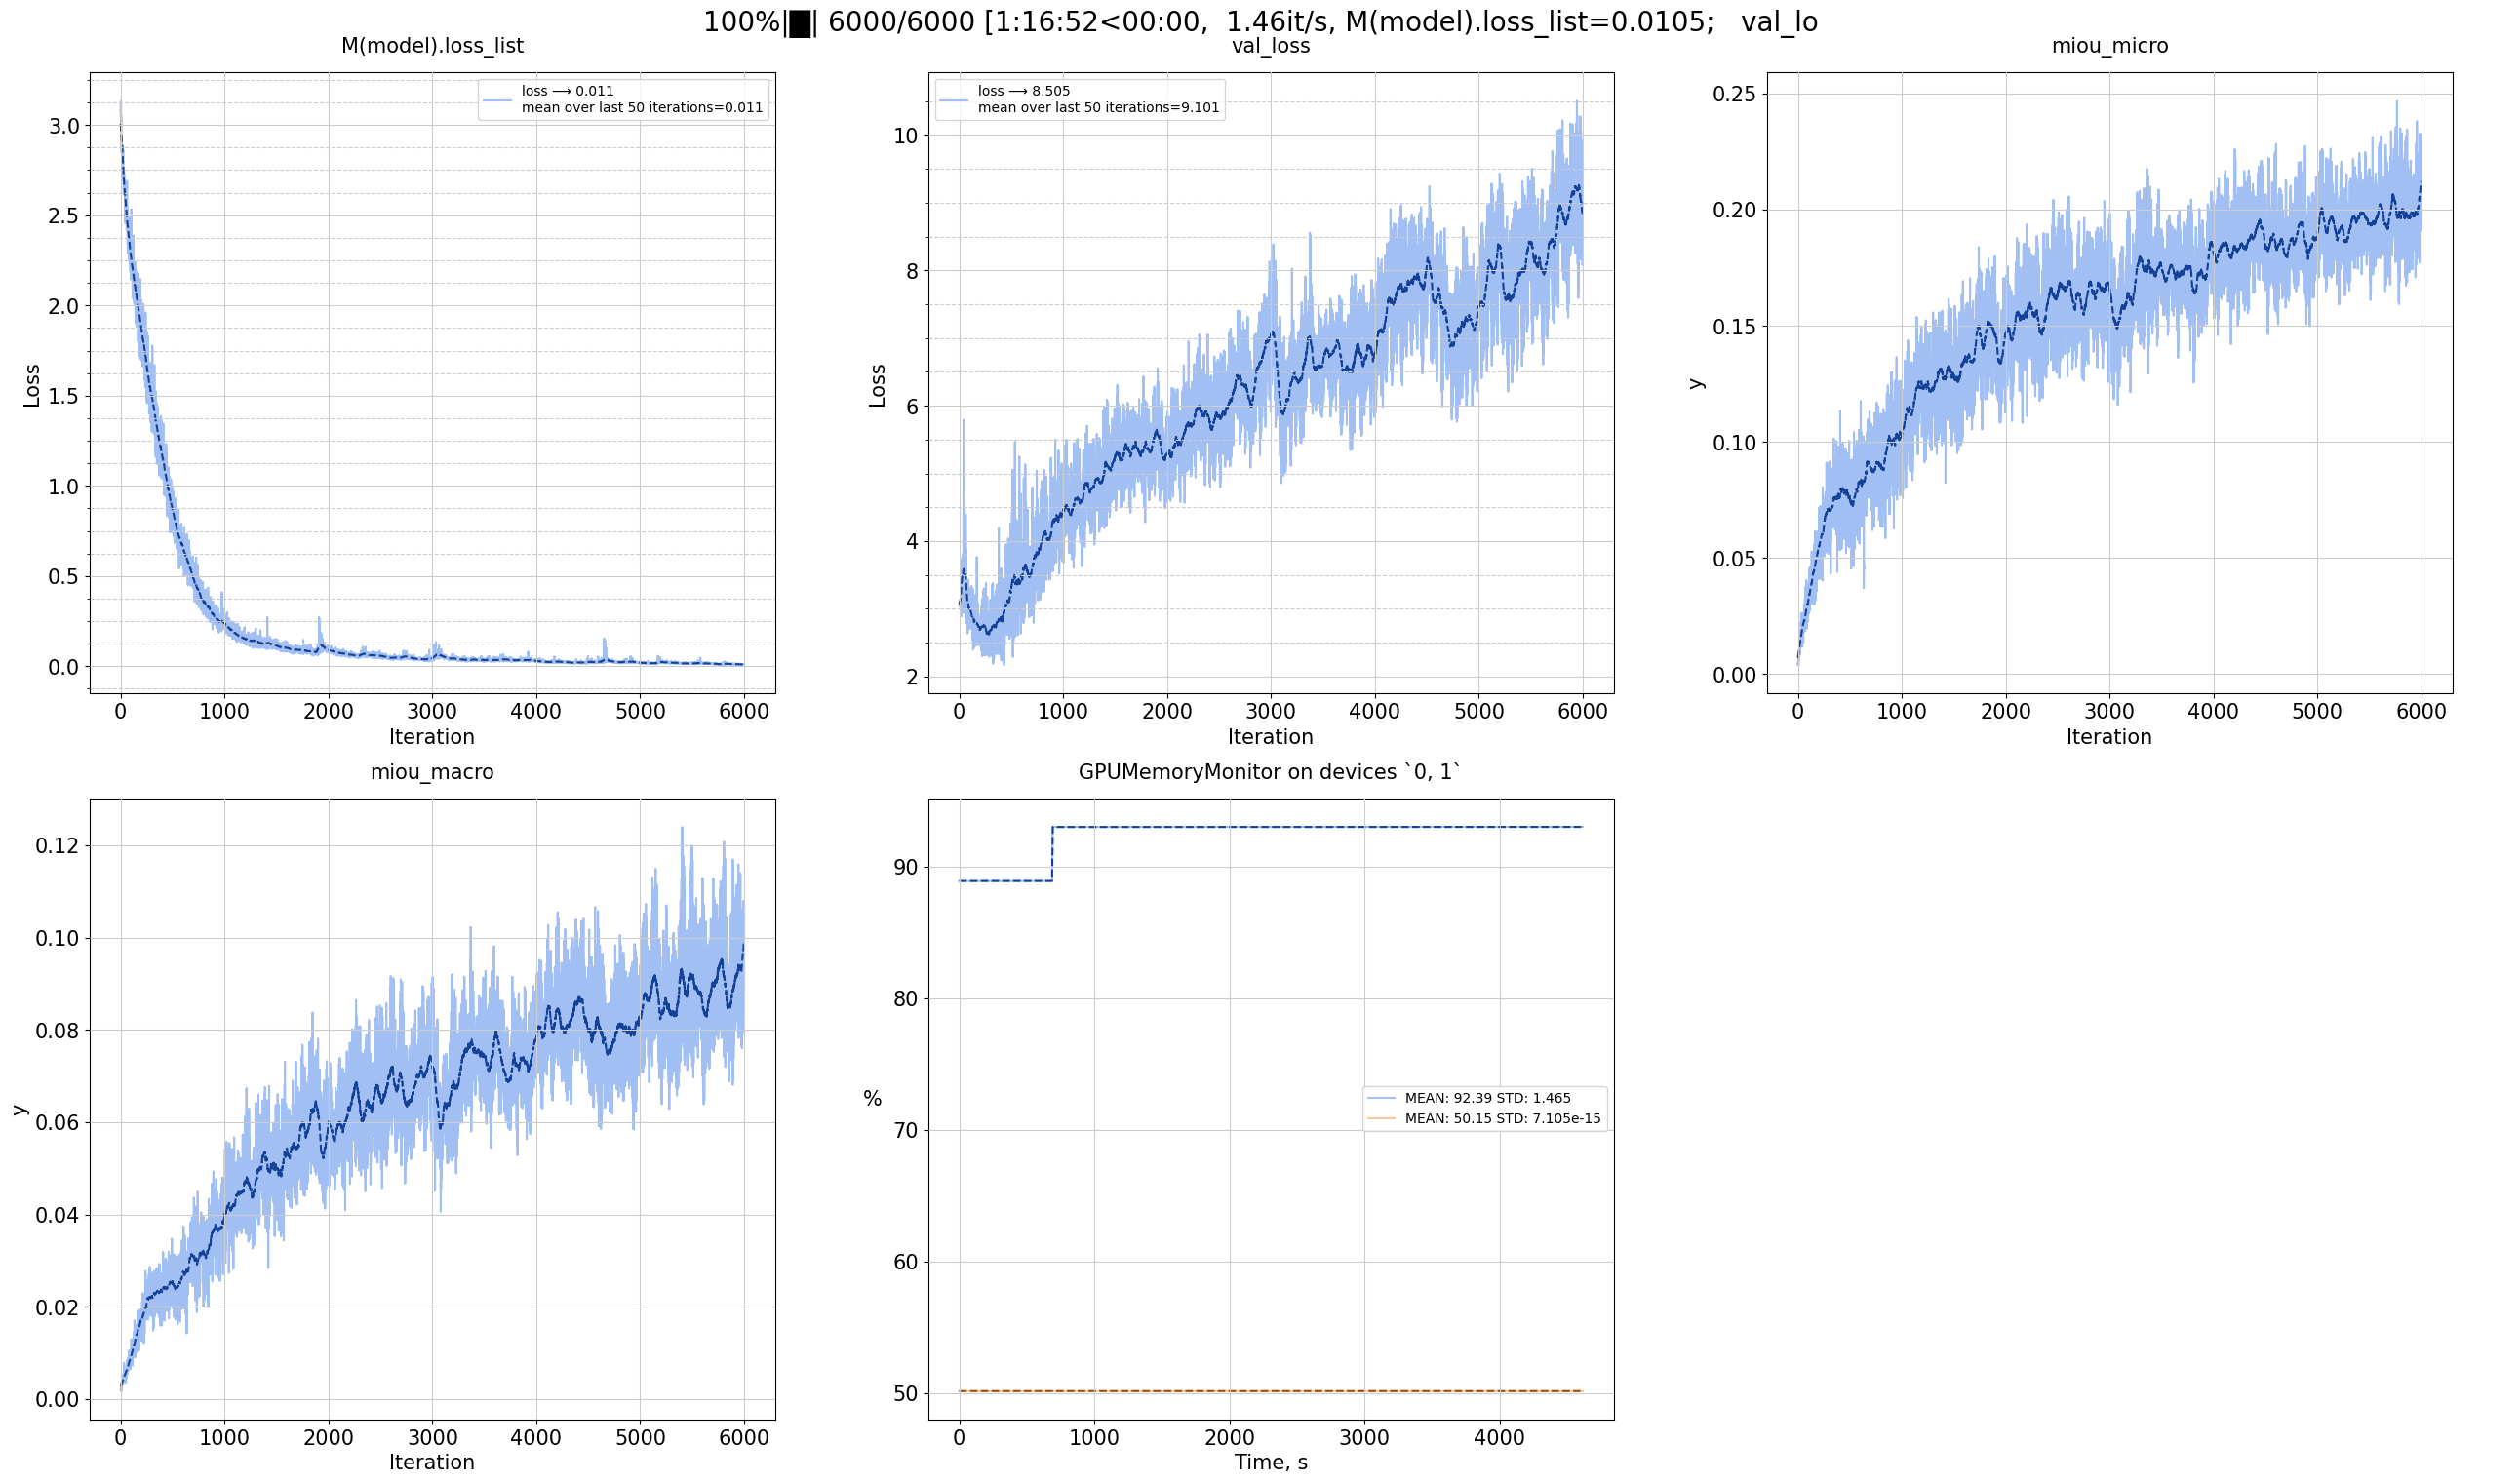

In [34]:
train_pipeline, val_pipeline = train(
    dataset=ds,
    config=config,
    loss={'name':' ce', 'squeeze': True, 'ignore_index': 255, 'weight': 'adaptive'}, 
    optimizer={'name': Lion, 'lr': train_params['LR']},
    train_params=train_params,
    n_iters=6000,
    visible_devices='0,1',
    frequency=100
)

In [35]:
test_pipeline = (
    Pipeline()
    .import_model('model', train_pipeline)
    .init_variable('images', [])
    .init_variable('predictions', [])
    .init_variable('masks', [])
    .init_variable('iou', [])

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.BILINEAR, src='images', dst='images')
    .to_array(channels='first', dtype=np.float32, src='images', dst='images')

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.NEAREST, src='labels', dst='masks')
    .to_array(channels='first', dtype=np.int64, src='masks', dst='masks')

    .predict_model('model', inputs=B.images,
                   outputs='predictions', save_to=V('predictions', mode='a'))
    .update(V('images', mode='a'), B.images)
    .update(V('masks', mode='a'), B.masks)
    .mIoU(preds=V.predictions[-1], mask=B('masks'), num_classes=train_params['NUM_CLASSES'], save_to=V('iou', mode='a'))
) << ds.test

test_pipeline = test_pipeline.run(batch_size=1, shuffle=False, n_epochs=1, drop_last=False, bar=True)

  0%|                                                                                                         …

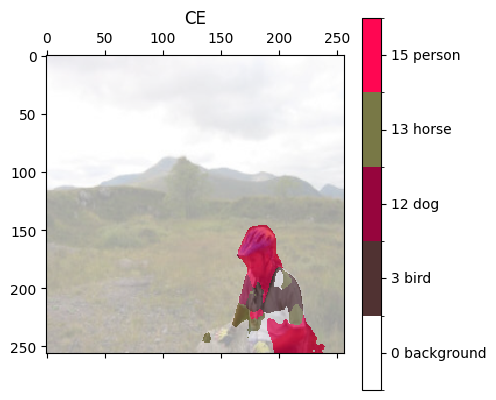

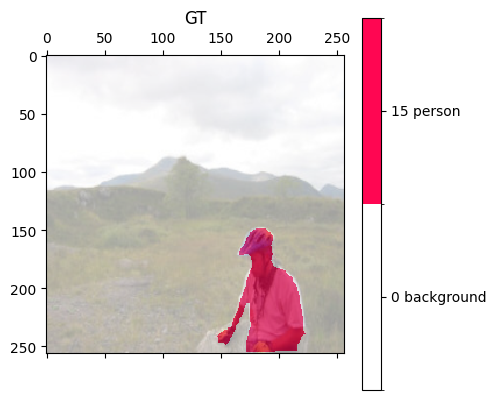

In [56]:
plot_prediction(pipeline=test_pipeline, image_number=50, dataset='pascal', title='CE')